In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
from singleVis.vis_models import vis_models
from singleVis.data import NormalDataProvider
from singleVis.projector import DVIProjector

from config import load_cfg
########################################################################################################################
#                                                     DVI PARAMETERS                                                   #
########################################################################################################################
"""DVI with semantic temporal edges"""
VIS_METHOD = "tdvi" # DeepVisualInsight

2025-07-23 22:19:49.195508: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 22:19:49.207620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753280389.221815 1918038 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753280389.225953 1918038 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753280389.237087 1918038 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# CONTENT_PATH = "/data2/xianglin/SentryCam/ResNet_CIFAR100_UNSTABLE"
CONTENT_PATH = "/data2/xianglin/SentryCam/ResNet_CIFAR100"


In [3]:
########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################

sys.path.append(CONTENT_PATH)
config = load_cfg(os.path.join(CONTENT_PATH, "config", f"{VIS_METHOD}.yaml"))
print(config)

SETTING = config.SETTING
CLASSES = config.CLASSES
DATASET = config.DATASET
PREPROCESS = config.VISUALIZATION.PREPROCESS
GPU_ID = config.GPU
EPOCH_START = config.EPOCH_START
EPOCH_END = config.EPOCH_END
EPOCH_PERIOD = config.EPOCH_PERIOD
EPOCH_NAME = config.EPOCH_NAME

# Training parameter (subject model)
TRAINING_PARAMETER = config.TRAINING
NET = TRAINING_PARAMETER.NET
LEN = TRAINING_PARAMETER.train_num

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config.VISUALIZATION
SAVE_BATCH_SIZE = VISUALIZATION_PARAMETER.SAVE_BATCH_SIZE
LAMBDA = VISUALIZATION_PARAMETER.LAMBDA
B_N_EPOCHS = VISUALIZATION_PARAMETER.BOUNDARY.B_N_EPOCHS
L_BOUND = VISUALIZATION_PARAMETER.BOUNDARY.L_BOUND
ENCODER_DIMS = VISUALIZATION_PARAMETER.ENCODER_DIMS
DECODER_DIMS = VISUALIZATION_PARAMETER.DECODER_DIMS
S_N_EPOCHS = VISUALIZATION_PARAMETER.S_N_EPOCHS
T_N_EPOCHS = VISUALIZATION_PARAMETER.T_N_EPOCHS
N_NEIGHBORS = VISUALIZATION_PARAMETER.N_NEIGHBORS
PATIENT = VISUALIZATION_PARAMETER.PATIENT
MAX_EPOCH = VISUALIZATION_PARAMETER.MAX_EPOCH
VIS_MODEL = VISUALIZATION_PARAMETER.VIS_MODEL
METRIC = VISUALIZATION_PARAMETER.METRIC

VIS_MODEL_NAME = f"{VIS_METHOD}"
EVALUATION_NAME = f"evaluation_{VIS_MODEL_NAME}"

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

########################################################################################################################
#                                                    TRAINING SETTING                                                  #
########################################################################################################################
# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name=EPOCH_NAME, verbose=1)
# Define visualization models
model = vis_models[VIS_MODEL](ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, epoch_name=EPOCH_NAME, device=DEVICE)


CLASSES: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
DATASET: CIFAR100
EPOCH_END: 200
EPOCH_NAME: Epoch
EPOCH_PERIOD: 1
EPOCH_START: 1
GPU: 0
SETTING: normal
TRAINING:
  NET: resnet34
  test_num: 10000
  train_num: 50000
VISUALIZATION:
  ALPHA: 0.0
  BETA: 0.1
  BOUNDARY:
    B_N_EPOCHS: 0
    L_BOUND: 0.4
  DECODER_DIMS: [2, 32, 64, 128, 256, 512]
  Delay: 1
  Delay_time: 32
  ENCODER_DIMS: [512, 256, 128, 64, 32, 2]
  INIT_NUM: 300
  LAMBDA: 1.0
  LAMBDA1: 1.0
  LAMBDA2: 0.3
  MAX_EPOCH: 20
  METRIC: euclidean
  N_NEIGHBORS: 15
  PATIENT: 3
  PREPROCESS: 1
  RESOLUTION: 300
  SAVE_BATCH_SIZE: 5000
  S_N_EPOCHS: 3
  T_N_EPOCHS: 2
  VIS_MODEL: c

In [4]:
########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################
from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200)
save_dir = os.path.join(data_provider.content_path, "img")
os.makedirs(save_dir, exist_ok=True)

# Identifying unstable point

In [5]:
from singleVis.training_dynamics import TD

td = TD(data_provider, projector, range=(1, 25, 1))

# get loss history

loss_history = td.loss_dynamics(train=True)
valid_loss_history = td.loss_dynamics(train=False)

# get visualization history
visualization_history = td.position_dynamics()
representation_history = td.position_high_dynamics()

# get label 
labels = td.data_provider.train_labels(1)

loss_history.shape, visualization_history.shape, labels.shape

/home/xianglin/git_space/SentryCam/singleVis/data.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_labels = torch.load(training_data_loc, map_location="cpu")
/

/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_1/test_index.json


100%|██████████| 5/5 [00:00<00:00, 625.40it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_2/test_index.json


100%|██████████| 5/5 [00:00<00:00, 774.63it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_3/test_index.json


100%|██████████| 5/5 [00:00<00:00, 1798.74it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_4/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2025.06it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_5/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2359.00it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_6/test_index.json


100%|██████████| 5/5 [00:00<00:00, 1152.41it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_7/test_index.json


100%|██████████| 5/5 [00:00<00:00, 943.77it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_8/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2306.84it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_9/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2266.95it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_10/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2305.07it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_11/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2269.40it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_12/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2111.94it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_13/test_index.json


100%|██████████| 5/5 [00:00<00:00, 907.82it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_14/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2361.66it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_15/test_index.json


100%|██████████| 5/5 [00:00<00:00, 969.92it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_16/test_index.json


100%|██████████| 5/5 [00:00<00:00, 1198.78it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_17/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2331.72it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_18/test_index.json


100%|██████████| 5/5 [00:00<00:00, 1705.69it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_19/test_index.json


100%|██████████| 5/5 [00:00<00:00, 929.63it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_20/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2336.14it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_21/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2314.23it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_22/test_index.json


100%|██████████| 5/5 [00:00<00:00, 1939.65it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_23/test_index.json


100%|██████████| 5/5 [00:00<00:00, 691.47it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_24/test_index.json


100%|██████████| 5/5 [00:00<00:00, 1934.64it/s]


/data2/xianglin/SentryCam/ResNet_CIFAR100/Model/Epoch_25/test_index.json


100%|██████████| 5/5 [00:00<00:00, 2124.13it/s]
/home/xianglin/git_space/SentryCam/singleVis/projector.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_model = tor

((50000, 25), (50000, 25, 2), (50000,))

In [6]:
loss_history.shape, valid_loss_history.shape

((50000, 25), (10000, 25))

In [7]:
loss_history = loss_history.mean(axis=0)
valid_loss_history = valid_loss_history.mean(axis=0)

loss_history.shape, valid_loss_history.shape

((25,), (25,))

In [8]:
from audit.metrics import analyze_and_plot_trajectories

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

# --- 1. METRIC CALCULATION FUNCTIONS (Input: Trajectory Data) ---
def calculate_dbi_trajectory(trajectories, labels):
    """
    Calculates the Davies-Bouldin Index for each time step in a trajectory.

    Args:
        trajectories (np.array): Shape (N, num_epochs, 2). The 2D embeddings over time.
        labels (np.array): Shape (N,). The class labels for each point.

    Returns:
        np.array: A 1D array of DBI scores, one for each epoch.
    """
    num_epochs = trajectories.shape[1]
    dbi_scores = []
    print("Calculating Davies-Bouldin Index trajectory...")
    for t in range(num_epochs):
        current_embedding = trajectories[:, t, :]
        # Check for edge case of a single cluster, which would crash DBI
        if len(np.unique(labels)) > 1:
            score = davies_bouldin_score(current_embedding, labels)
            dbi_scores.append(score)
        else: # If only one cluster, score is not well-defined. Append previous or 0.
            dbi_scores.append(dbi_scores[-1] if dbi_scores else 0)
    return np.array(dbi_scores)

def calculate_intra_cluster_variance_trajectory(trajectories, labels):
    """
    Calculates the Average Intra-Cluster Variance for each time step in a trajectory.

    Args:
        trajectories (np.array): Shape (N, num_epochs, 2). The 2D embeddings over time.
        labels (np.array): Shape (N,). The class labels for each point.

    Returns:
        np.array: A 1D array of variance scores, one for each epoch.
    """
    num_epochs = trajectories.shape[1]
    variance_scores = []
    print("Calculating Intra-Cluster Variance trajectory...")
    for t in range(num_epochs):
        current_embedding = trajectories[:, t, :]
        class_variances = []
        for c in np.unique(labels):
            class_points = current_embedding[labels == c]
            if len(class_points) > 1:
                centroid = class_points.mean(axis=0)
                variance = np.mean(np.sum((class_points - centroid)**2, axis=1))
                class_variances.append(variance)
        
        # Average the variance across all classes for this epoch
        if class_variances:
            variance_scores.append(np.mean(class_variances))
        else:
            variance_scores.append(variance_scores[-1] if variance_scores else 0)
            
    return np.array(variance_scores)

def calculate_inter_cluster_distance_trajectory(trajectories, labels):
    """
    Calculates the Average Inter-Cluster Distance for each time step.
    A higher value is better. A sharp decrease indicates collapse.
    """
    num_epochs = trajectories.shape[1]
    distance_scores = []
    print("Calculating Inter-Cluster Distance trajectory...")
    unique_labels = np.unique(labels)
    
    if len(unique_labels) < 2:
        return np.zeros(num_epochs) # Metric is undefined for a single cluster

    for t in range(num_epochs):
        current_embedding = trajectories[:, t, :]
        centroids = np.array([current_embedding[labels == c].mean(axis=0) for c in unique_labels])
        
        # Calculate pairwise distances between centroids and take the mean
        if len(centroids) > 1:
            dist_matrix = squareform(pdist(centroids, 'euclidean'))
            # Get sum of upper triangle (to avoid double counting) and normalize
            avg_dist = np.sum(np.triu(dist_matrix)) / (len(centroids) * (len(centroids) - 1) / 2)
            distance_scores.append(avg_dist)
        else:
            distance_scores.append(0)
            
    return np.array(distance_scores)

# --- 2. DYNAMIC THRESHOLDING (This function is unchanged) ---

def find_trigger_epoch(metric_values, epochs, strategy='derivative', higher_is_better=False, burn_in=5, **kwargs):
    """
    Finds the anomaly trigger epoch. Now handles both "lower is better" and "higher is better" metrics.
    """
    if len(metric_values) <= burn_in:
        return -1
    trigger_epoch = -1
    smoothed_metric = np.convolve(metric_values, np.ones(3)/3, mode='same')

    # Condition for an anomaly depends on whether higher or lower is better
    is_anomaly = (lambda current, prev: current < prev) if higher_is_better else (lambda current, prev: current > prev)

    if strategy == 'derivative':
        for i in range(burn_in, len(smoothed_metric)):
            if is_anomaly(smoothed_metric[i], smoothed_metric[i-1]):
                trigger_epoch = epochs[i]
                break
            # if is_anomaly(smoothed_metric[i], smoothed_metric[i-1]):
            #     trigger_epoch = epochs[i]
            #     break
    
    elif strategy == 'relative_to_best':
        tolerance = kwargs.get('tolerance', 0.2)
        # Find the best score during burn-in
        best_score = np.max(metric_values[:burn_in]) if higher_is_better else np.min(metric_values[:burn_in])
        if abs(best_score) < 1e-9: best_score = 1e-9 if best_score >= 0 else -1e-9

        # Threshold is a degradation from the best score
        threshold = best_score * (1 - tolerance) if higher_is_better else best_score * (1 + tolerance)
        
        for i in range(burn_in, len(metric_values)):
            if is_anomaly(metric_values[i], threshold):
                trigger_epoch = epochs[i]
                break
                
    elif strategy == 'std_dev_zscore':
        window_size = kwargs.get('window_size', 3)
        num_std_devs = kwargs.get('num_std_devs', 2.0)
        if len(metric_values) < burn_in + window_size: return -1
        
        for i in range(burn_in + window_size, len(metric_values)):
            window = metric_values[i-window_size : i]
            mean, std = np.mean(window), np.std(window)
            if std < 1e-9: continue
            
            # Anomaly is being too many std devs away from the mean in the "bad" direction
            threshold = mean - num_std_devs * std if higher_is_better else mean + num_std_devs * std
            
            if is_anomaly(metric_values[i], threshold):
                trigger_epoch = epochs[i]
                break

    return trigger_epoch
import numpy as np

def find_trigger_epoch_with_margin(
    metric_values, 
    epochs, 
    higher_is_better=False, 
    burn_in=5,
    k_consecutive=2,        # How many consecutive epochs of bad trend to require
    std_fraction_margin=0.2, # The margin: change must be > this * std_dev
    std_window_size = 10
):
    """
    Finds an anomaly trigger epoch based on a sustained trend that exceeds a dynamic,
    standard-deviation-based margin.
    """
    # Not enough history to evaluate a trend or the burn_in period
    if len(metric_values) < burn_in + k_consecutive:
        return -1
    
    # Iterate through the epochs, starting after the burn-in period
    for i in range(burn_in, len(metric_values)):
        
        # 1. Check for a sustained trend over the last k epochs
        # --------------------------------------------------------
        is_sustained_bad_trend = True
        # Ensure we have enough history for the check
        if i < k_consecutive -1: 
            continue
            
        for j in range(k_consecutive):
            # The indices to check are from i-j down to i-j-1
            # e.g., for k=2 at i=10: check (10 vs 9) and (9 vs 8)
            current_val = metric_values[i - j]
            prev_val = metric_values[i - j - 1]
            
            is_bad_direction = (current_val < prev_val) if higher_is_better else (current_val > prev_val)
            if not is_bad_direction:
                is_sustained_bad_trend = False
                break
        
        if not is_sustained_bad_trend:
            continue # The trend was not consistently bad, check next epoch

        # 2. If trend is sustained, check if the change is significant (exceeds margin)
        # --------------------------------------------------------------------------
        
        # Calculate the dynamic margin based on recent volatility
        # Ensure we don't go out of bounds at the start
        window_start_idx = max(0, i - std_window_size)
        recent_window = metric_values[window_start_idx : i]
        
        if len(recent_window) < 2:
            std_dev = 0
        else:
            std_dev = np.std(recent_window)

        margin = std_dev * std_fraction_margin
        
        # We only need to check if the *last* step in the trend was significant
        last_step_change = abs(metric_values[i] - metric_values[i-1])
        
        if last_step_change > margin:
            # Both conditions are met: sustained trend AND significant change
            return epochs[i]
            
    # If the loop finishes without finding a trigger
    return -1

# --- 3. MAIN ANALYSIS & PLOTTING FUNCTION ---

def analyze_and_plot_trajectories(
    sentrycam_trajectories, 
    high_trajectory,
    all_labels, 
    loss_trajectory, 
    valid_loss_trajectory,
    scenario_type, 
    trigger_strategy='derivative',
    burn_in=5
):
    """
    Analyzes pre-computed trajectories using a 2D health space (Inter vs. Intra cluster metrics)
    and generates a comprehensive diagnostic plot.
    """
    num_epochs = sentrycam_trajectories.shape[1]
    epochs = np.arange(1, num_epochs + 1)
    
    print(f"\n--- Analyzing Scenario: '{scenario_type}' with 2D Health Metrics ---")

    # --- Step 1: Calculate both core geometric metric trajectories ---
    intra_variance_traj = calculate_intra_cluster_variance_trajectory(sentrycam_trajectories, all_labels)
    inter_distance_traj = calculate_inter_cluster_distance_trajectory(sentrycam_trajectories, all_labels)

    high_intra_variance_traj = calculate_intra_cluster_variance_trajectory(high_trajectory, all_labels)
    high_inter_distance_traj = calculate_inter_cluster_distance_trajectory(high_trajectory, all_labels)

    # --- Step 2: Find trigger epochs with the new margin-aware function ---
    t_sentry_trigger_1 = find_trigger_epoch_with_margin(inter_distance_traj, epochs, higher_is_better=True, burn_in=burn_in)
    t_sentry_trigger_2 = find_trigger_epoch_with_margin(intra_variance_traj, epochs, higher_is_better=False, burn_in=burn_in)
    
    # Handle the case where one trigger is -1 (not found)
    if t_sentry_trigger_1 == -1: t_sentry_trigger_1 = float('inf')
    if t_sentry_trigger_2 == -1: t_sentry_trigger_2 = float('inf')
    t_sentry_trigger = min(t_sentry_trigger_1, t_sentry_trigger_2)
    if t_sentry_trigger == float('inf'): t_sentry_trigger = -1 # Reset if neither triggered
    
    t_high_sentry_trigger_1 = find_trigger_epoch_with_margin(high_inter_distance_traj, epochs, higher_is_better=True, burn_in=burn_in)
    t_high_sentry_trigger_2 = find_trigger_epoch_with_margin(high_intra_variance_traj, epochs, higher_is_better=False, burn_in=burn_in)

    if t_high_sentry_trigger_1 == -1: t_high_sentry_trigger_1 = float('inf')
    if t_high_sentry_trigger_2 == -1: t_high_sentry_trigger_2 = float('inf')
    t_high_sentry_trigger = min(t_high_sentry_trigger_1, t_high_sentry_trigger_2)
    if t_high_sentry_trigger == float('inf'): t_high_sentry_trigger = -1
    
    # Use the validation loss for the loss trigger
    t_loss_trigger = find_trigger_epoch_with_margin(valid_loss_trajectory, epochs, higher_is_better=False, burn_in=burn_in)

    # --- Step 3: Print Quantitative Results ---
    print(f"\n--- Anomaly Detection Results ('{trigger_strategy}' strategy) ---")
    print(f"SentryCam trigger at Epoch: {t_sentry_trigger}")
    print(f"High-quality trigger at Epoch: {t_high_sentry_trigger}")
    print(f"Loss-based trigger (starts rising) at Epoch: {t_loss_trigger}")
    if t_sentry_trigger != -1 and t_loss_trigger != -1:
        early_warning_epochs = t_loss_trigger - t_sentry_trigger
        if early_warning_epochs > 0:
            print(f"SentryCam provided a {early_warning_epochs}-epoch early warning!")

    # --- Step 4: Generate the 2D Cluster Health Trajectory Plot ---
    fig = plt.figure(figsize=(24, 8))
    gs = fig.add_gridspec(1, 3)
    
    # === Panel (a): The new 2D Cluster Health Trajectory ===
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title("Panel (a): 2D Cluster Health Trajectory", fontweight='bold')
    ax1.set_xlabel("Intra-Cluster Variance")
    ax1.set_ylabel("Inter-Cluster Distance")

    # Combine metrics into a list of (x, y) points for plotting
    health_points = np.column_stack((intra_variance_traj, inter_distance_traj))

    if t_sentry_trigger != -1:
        health_points = health_points[:t_sentry_trigger, :]

    
    # Plot the trajectory path, color-coded by epoch
    scatter = ax1.scatter(health_points[:, 0], health_points[:, 1], c=epochs[:t_sentry_trigger] if t_sentry_trigger != -1 else epochs, cmap='viridis', s=40, zorder=3)
    cbar = fig.colorbar(scatter, ax=ax1, orientation='vertical')
    cbar.set_label("Epoch")

    # Draw arrows to show the direction of training
    for i in range(1, len(health_points)):
        ax1.annotate("",
                     xy=health_points[i], xycoords='data',
                     xytext=health_points[i-1], textcoords='data',
                     arrowprops=dict(arrowstyle="->", color="black", alpha=0.4,
                                     shrinkA=5, shrinkB=5,
                                     patchA=None, patchB=None,
                                     connectionstyle="arc3,rad=0.1"))

    # Highlight and label key points
    ax1.plot(health_points[0, 0], health_points[0, 1], 'o', c='red', markersize=10, label='Start (Epoch 1)', zorder=4)
    if t_sentry_trigger != -1:
        trigger_idx = t_sentry_trigger - 1
        ax1.plot(health_points[trigger_idx, 0], health_points[trigger_idx, 1], 'X', c='orange', markersize=12, label=f'SentryCam Alert (Epoch {t_sentry_trigger})', zorder=5)
    
    # Mark the ideal "goal" region
    ideal_x_thresh = np.percentile(intra_variance_traj, 20)
    ideal_y_thresh = np.percentile(inter_distance_traj, 80)
    ax1.axvspan(0, ideal_x_thresh, color='green', alpha=0.1, zorder=0, label='Ideal Region')
    ax1.axhspan(ideal_y_thresh, health_points[:, 1].max() * 1.1, color='green', alpha=0.1, zorder=0)
    
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # === Panel (b): The high-quality Cluster Health Trajectory ===
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Panel (b): High-quality Cluster Health Trajectory", fontweight='bold')
    ax2.set_xlabel("Intra-Cluster Variance")
    ax2.set_ylabel("Inter-Cluster Distance")

    # Combine metrics into a list of (x, y) points for plotting
    high_health_points = np.column_stack((high_intra_variance_traj, high_inter_distance_traj))

    if t_high_sentry_trigger != -1:
        high_health_points = high_health_points[:t_high_sentry_trigger, :]
    
    # Plot the trajectory path, color-coded by epoch
    scatter = ax2.scatter(high_health_points[:, 0], high_health_points[:, 1], c=epochs[:t_high_sentry_trigger] if t_high_sentry_trigger != -1 else epochs, cmap='viridis', s=40, zorder=3)
    cbar = fig.colorbar(scatter, ax=ax2, orientation='vertical')
    cbar.set_label("Epoch")

    # Draw arrows to show the direction of training
    for i in range(1, len(high_health_points)):
        ax2.annotate("",
                     xy=high_health_points[i], xycoords='data',
                     xytext=high_health_points[i-1], textcoords='data',
                     arrowprops=dict(arrowstyle="->", color="black", alpha=0.4,
                                     shrinkA=5, shrinkB=5,
                                     patchA=None, patchB=None,
                                     connectionstyle="arc3,rad=0.1"))

    # Highlight and label key points
    ax2.plot(high_health_points[0, 0], high_health_points[0, 1], 'o', c='red', markersize=10, label='Start (Epoch 1)', zorder=4)
    if t_high_sentry_trigger != -1:
        trigger_idx = t_high_sentry_trigger - 1
        ax2.plot(high_health_points[trigger_idx, 0], high_health_points[trigger_idx, 1], 'X', c='orange', markersize=12, label=f'High-quality Alert (Epoch {t_high_sentry_trigger})', zorder=5)
    
    # Mark the ideal "goal" region
    ideal_x_thresh = np.percentile(high_intra_variance_traj, 20)
    ideal_y_thresh = np.percentile(high_inter_distance_traj, 80)
    ax2.axvspan(0, ideal_x_thresh, color='green', alpha=0.1, zorder=0, label='Ideal Region')
    ax2.axhspan(ideal_y_thresh, high_health_points[:, 1].max() * 1.1, color='green', alpha=0.1, zorder=0)
    
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    # === Panel (c): Traditional Loss Curve for Context ===
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_title("Panel (c): Validation Loss Curve", fontweight='bold')
    ax3.plot(epochs, loss_trajectory, '-o', color='red', label='Training Loss')
    ax3.plot(epochs, valid_loss_trajectory, '-o', color='blue', label='Validation Loss')
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Validation Loss")
    
    # Annotate with triggers for comparison
    if t_loss_trigger != -1:
        ax3.axvline(x=t_loss_trigger, color='red', linestyle='--', label=f'Loss Alert (Epoch {t_loss_trigger})')
    if t_sentry_trigger != -1:
        ax3.axvline(x=t_sentry_trigger, color='blue', linestyle='--', label=f'SentryCam Alert (Epoch {t_sentry_trigger})')
    if t_high_sentry_trigger != -1:
        ax3.axvline(x=t_high_sentry_trigger, color='green', linestyle='--', label=f'High-quality Alert (Epoch {t_high_sentry_trigger})')
    
    ax3.legend()
    ax3.grid(True, linestyle='--')

    # # === Panel (d): SentryCam View ===
    # ax = fig.add_subplot(gs[0, 3])
    # emb = sentrycam_trajectories[:, t_sentry_trigger - 1, :]
    # scatter = ax.scatter(emb[:, 0], emb[:, 1], c=all_labels, cmap='Spectral', s=5, alpha=0.7)
    # ax.set_title(f"SentryCam View (Epoch {t_sentry_trigger})")
    # ax.set_xticks([]); ax.set_yticks([])

    # ax = fig.add_subplot(gs[0, 4])
    # emb = sentrycam_trajectories[:, t_high_sentry_trigger - 1, :]
    # scatter = ax.scatter(emb[:, 0], emb[:, 1], c=all_labels, cmap='Spectral', s=5, alpha=0.7)
    # ax.set_title(f"SentryCam View (Epoch {t_high_sentry_trigger})")
    # ax.set_xticks([]); ax.set_yticks([])

    # fig.colorbar(scatter, ax=ax, label='Class Label')
    # fig.tight_layout()
    # plt.suptitle(f"Diagnostic Analysis for Scenario: {scenario_type.title()}", fontsize=16, y=1.02)
    # plt.show()
    
    plt.suptitle(f"SentryCam Diagnostic for '{scenario_type.title()}' Scenario", fontsize=16, y=1.0)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


--- Analyzing Scenario: 'unstable' with 2D Health Metrics ---
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...

--- Anomaly Detection Results ('derivative' strategy) ---
SentryCam trigger at Epoch: 7
High-quality trigger at Epoch: 8
Loss-based trigger (starts rising) at Epoch: 14
SentryCam provided a 7-epoch early warning!


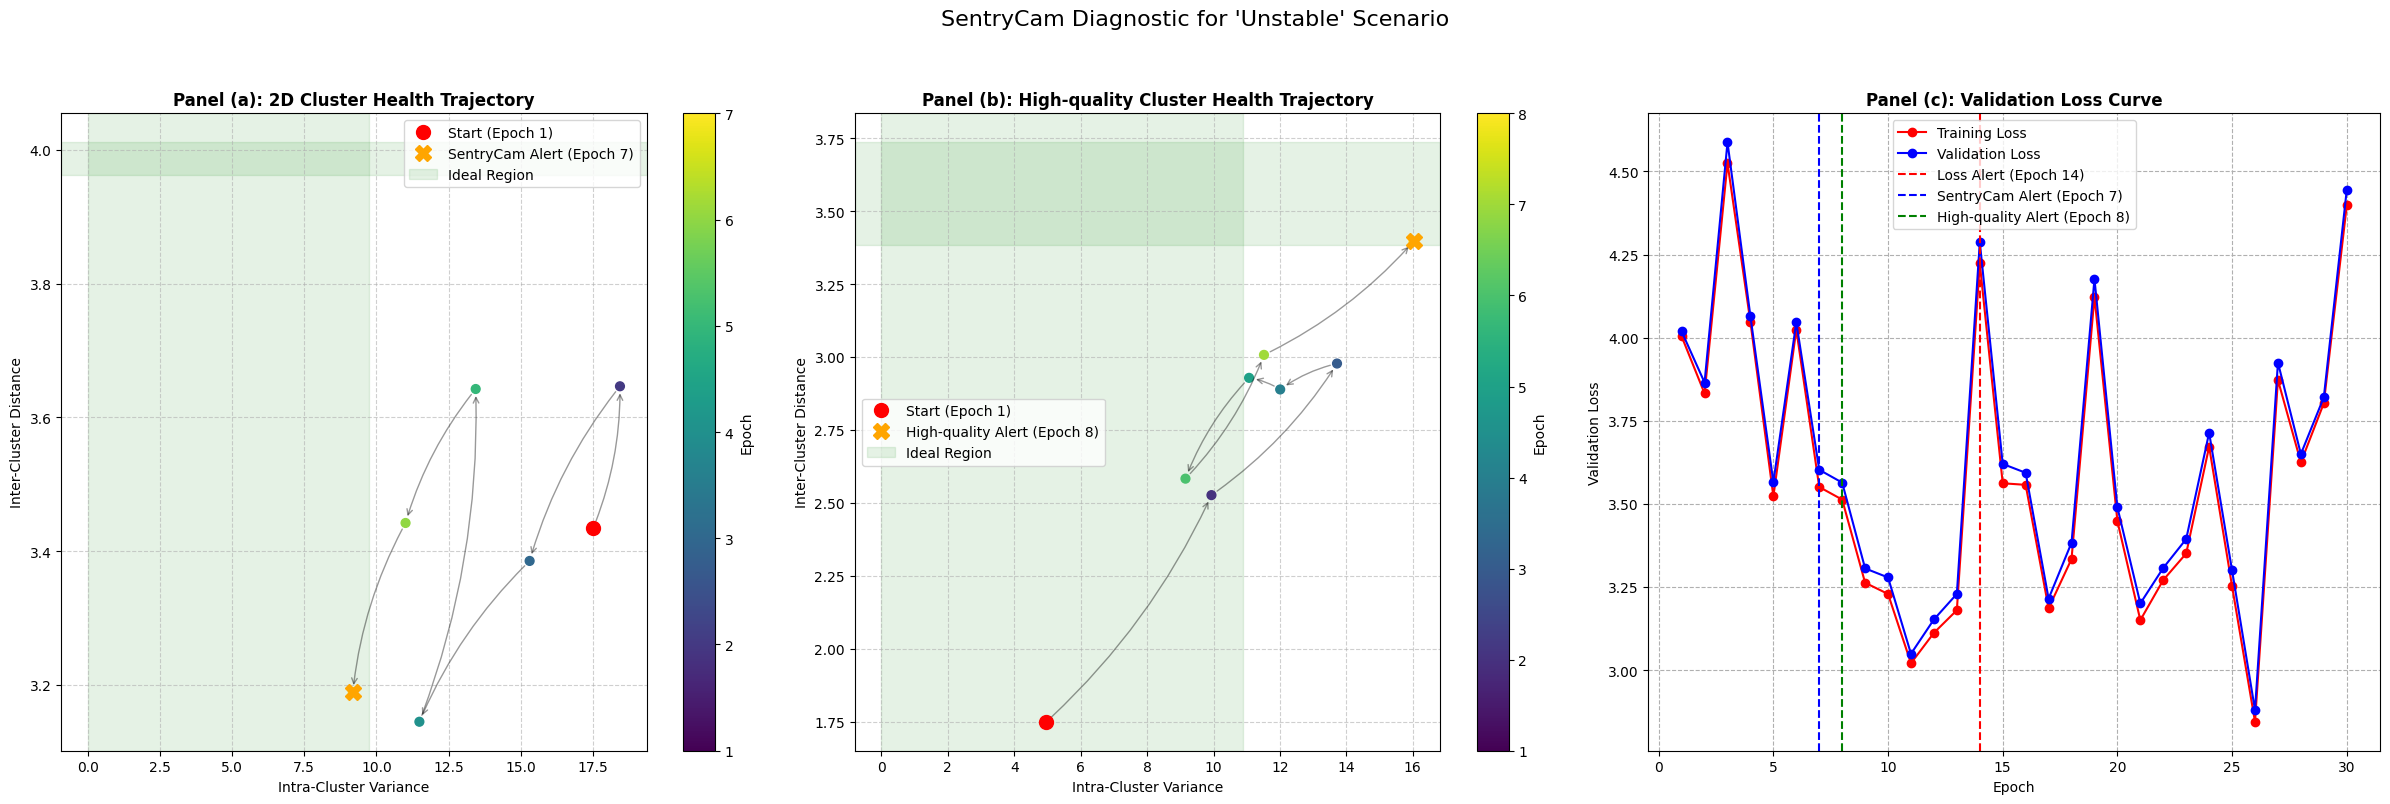

In [17]:
# SCENARIO = 'forgetting'
SCENARIO = 'unstable'

STRATEGY = 'derivative'
# STRATEGY = 'relative_to_best'
# STRATEGY = 'std_dev_zscore'

# 1. Generate mock data in the specified format
t = 5

# 2. Analyze the trajectories
analyze_and_plot_trajectories(
    sentrycam_trajectories=visualization_history,
    high_trajectory=representation_history,
    all_labels=labels,
    loss_trajectory=loss_history,
    valid_loss_trajectory=valid_loss_history,
    scenario_type=SCENARIO,
    trigger_strategy=STRATEGY,
    burn_in=t
)


--- Analyzing Scenario: 'unstable' with 2D Health Metrics ---
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...

--- Anomaly Detection Results ('derivative' strategy) ---
SentryCam trigger at Epoch: -1
High-quality trigger at Epoch: 25
Loss-based trigger (starts rising) at Epoch: 27


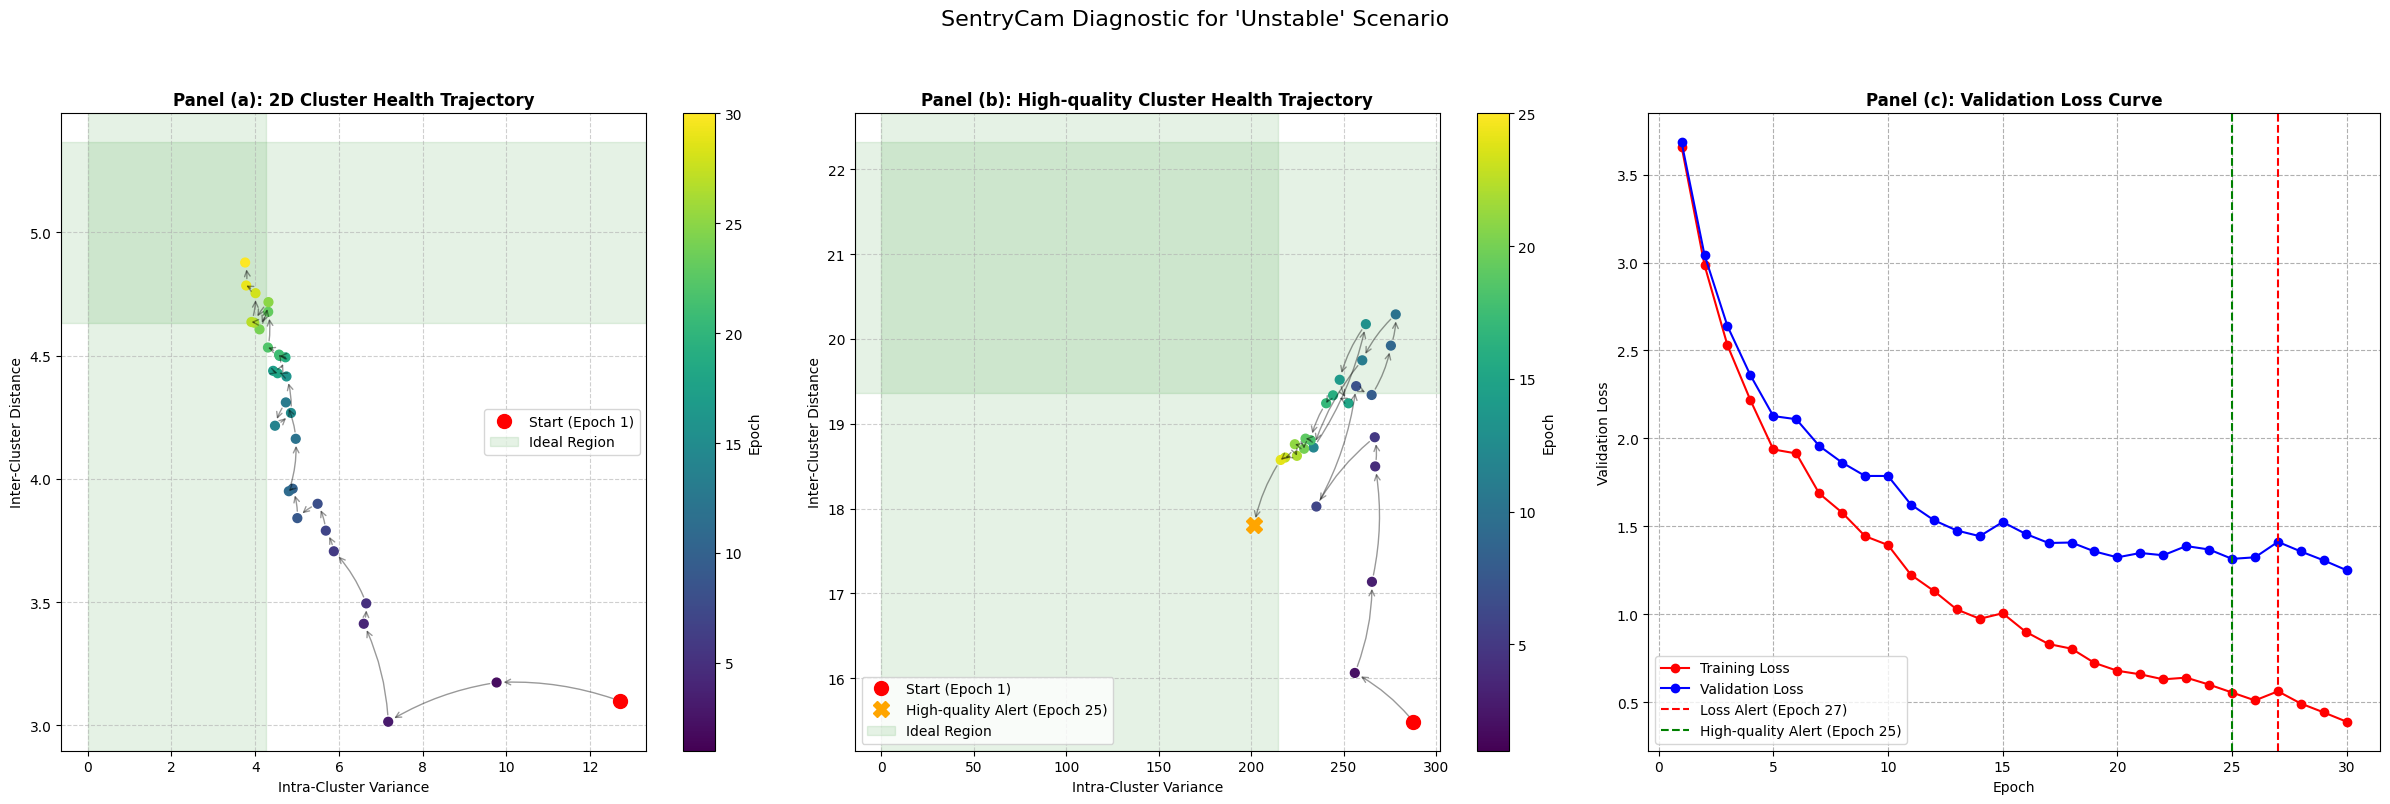

In [ ]:
# SCENARIO = 'forgetting'
SCENARIO = 'unstable'

STRATEGY = 'derivative'
# STRATEGY = 'relative_to_best'
# STRATEGY = 'std_dev_zscore'

# 1. Generate mock data in the specified format
t = 5

# 2. Analyze the trajectories
analyze_and_plot_trajectories(
    sentrycam_trajectories=visualization_history,
    high_trajectory=representation_history,
    all_labels=labels,
    loss_trajectory=loss_history,
    valid_loss_trajectory=valid_loss_history,
    scenario_type=SCENARIO,
    trigger_strategy=STRATEGY,
    burn_in=t
)


--- Analyzing Scenario: 'unstable' with 2D Health Metrics ---
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...
Calculating Intra-Cluster Variance trajectory...
Calculating Inter-Cluster Distance trajectory...

--- Anomaly Detection Results ('derivative' strategy) ---
SentryCam trigger at Epoch: -1
High-quality trigger at Epoch: 25
Loss-based trigger (starts rising) at Epoch: -1


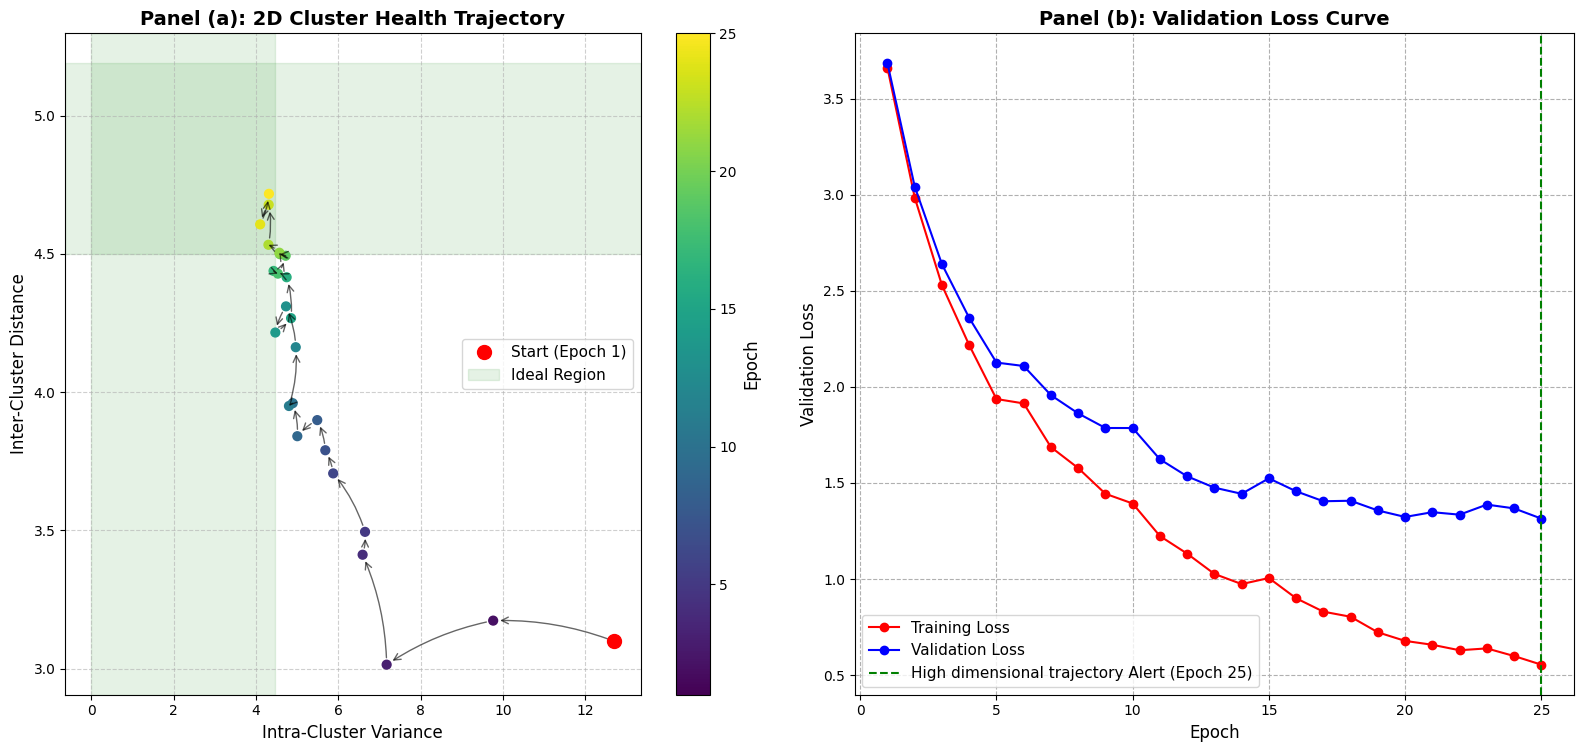

In [9]:
# SCENARIO = 'forgetting'
SCENARIO = 'unstable'

STRATEGY = 'derivative'
# STRATEGY = 'relative_to_best'
# STRATEGY = 'std_dev_zscore'

# 1. Generate mock data in the specified format
t = 20

# 2. Analyze the trajectories
analyze_and_plot_trajectories(
    sentrycam_trajectories=visualization_history,
    high_trajectory=representation_history,
    all_labels=labels,
    loss_trajectory=loss_history,
    valid_loss_trajectory=valid_loss_history,
    scenario_type=SCENARIO,
    trigger_strategy=STRATEGY,
    burn_in=t,
    save_name='stable_training.pdf'
)